In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
import numpy as np

from src import Household

In [2]:
buyer = Household(name="가구 1", kwh=420).set_rate("단일", "기타")

print("현재요금", buyer.basic, buyer.elec_rate, buyer.basic + buyer.elec_rate)

현재요금 7300 61852.0 69152.0


In [3]:
seller = Household(name="가구 2", kwh=150).set_rate("단일", "기타")

print("현재요금", seller.basic, seller.elec_rate, seller.basic + seller.elec_rate)

현재요금 910 13995.0 14905.0


In [4]:
seller = Household(name="가구 2", kwh=410).set_rate("단일", "기타")

print("현재요금", seller.basic, seller.elec_rate, seller.basic + seller.elec_rate)

현재요금 7300 59046.0 66346.0


In [5]:
seller = Household(name="가구 2", kwh=390).set_rate("단일", "기타")

print("현재요금", seller.basic, seller.elec_rate, seller.basic + seller.elec_rate)

현재요금 1600 54361.0 55961.0


In [6]:
seller = Household(name="가구 2", kwh=180).set_rate("단일", "기타")

print("현재요금", seller.basic, seller.elec_rate, seller.basic + seller.elec_rate)

현재요금 910 16794.0 17704.0


In [7]:
seller = Household(name="가구 2", kwh=200).set_rate("단일", "기타")

print("현재요금", seller.basic, seller.elec_rate, seller.basic + seller.elec_rate)

현재요금 910 18660.0 19570.0


In [8]:
other = Household(name="가구 3", kwh=300).set_rate("단일", "기타")

print("현재요금", other.basic, other.elec_rate, other.basic + other.elec_rate)

현재요금 1600 37450.0 39050.0


In [9]:
other = Household(name="가구 3", kwh=280).set_rate("단일", "기타")

print("현재요금", other.basic, other.elec_rate, other.basic + other.elec_rate)

현재요금 1600 33692.0 35292.0


In [10]:
households_kwh = (410 + 420 + 150)
public_kwh = 260

(households_kwh + public_kwh)

1240

In [11]:
201563 - 9709 - 63956 - 66346

61552

In [140]:
apt = Household(name="APT", kwh=413).set_rate("단일", "기타")

print("현재요금", apt.basic * 3, apt.elec_rate * 3, (apt.basic + apt.elec_rate) * 3)

현재요금 21900 179663.40000000002 201563.40000000002


In [117]:
(159991 - 9709 - 63956 - 39050) / 3

15758.666666666666

In [163]:
66347-4259

62088

In [166]:
70071 / 3

23357.0

In [167]:
23357 - 20517

2840

In [149]:
66346 + 17053 + 3464

86863

In [130]:
(3758 - 1866 + 1732) / 2

1812.0

In [131]:
(3758 + 1866) / 2

2812.0

In [12]:
# 서비스 소개 알고리즘 정리

# 판매 권장 고객 ? 누진 1단계 사용 고객
print("고객 {}은 판매 권장고객입니다.\n".format(seller.name))

# 여기서 예측기가 붙을 거임
predict_kwh = 170
print("현재 사용량은 {}kWh이며, 이번달 예측 사용량은 {}kWh입니다.\n".format(
    seller.kwh,
    predict_kwh
))

# 거래 추천
# 아마 가장 단순하게는 누진 2단계 시작 구간인 200kWh - 예측 사용량 170kWh를 빼는 형식으로 추천이 될거임
reco_trading_kwh = 200 - predict_kwh
print("사용량 {}kwh의 거래를 추천해드립니다.\n".format(reco_trading_kwh))

# 현재 상태에서 거래를 진행했을 경우의 가격을 우선적으로 계산하겠지?
after_seller = Household(name="가구 2", kwh=seller.kwh + reco_trading_kwh).set_rate("단일", "기타")
print("거래 진행 시, 고객님의 사용량은 {}kWh가 되며,\n".format(after_seller.kwh)
     + "전기요금계는 {}원에서 {}원으로 {}원 증가합니다.\n\n".format(
         seller.basic + seller.elec_rate,
         after_seller.basic + after_seller.elec_rate,
         (after_seller.basic + after_seller.elec_rate) - (seller.basic + seller.elec_rate)
     ))

# 그러면 아마 이 고객이 가장 이득을 얻을 수 있는 구매자를 찾아낼 것임
print("고객 {}와의 거래를 추천드립니다.".format(buyer.name))
# 그리고 buyer의 가격도 우선 측정하겠지?
after_buyer = Household(name="가구 1", kwh=buyer.kwh - reco_trading_kwh).set_rate("단일", "기타")
print("거래 진행 시, 구매자의 사용량은 {}kWh가 되며,\n".format(after_buyer.kwh)
     + "전기요금계는 {}원에서 {}원으로 {}원 감소합니다.\n\n".format(
         buyer.basic + buyer.elec_rate,
         after_buyer.basic + after_buyer.elec_rate,
         (buyer.basic + buyer.elec_rate) - (after_buyer.basic + after_buyer.elec_rate)
     ))

# 이 때 상품의 가치는 고객 2가 최소로는 받아야하는 금액 (eq. 올라간 금액만큼의 금액) 부터
# 고객 1과의 거래 시, 최대로 요구할 수 있는 가격이 온다. (eq. 구매자에게 내려간 금액, 구매자가 지불해도 구매자가 손해를 보지 않는 금액)
min_val = (after_seller.basic + after_seller.elec_rate) - (seller.basic + seller.elec_rate)
max_val = (buyer.basic + buyer.elec_rate) - (after_buyer.basic + after_buyer.elec_rate)
print("거래 진행 시, 거래사용량 {}kWh의 상품 가치는 {}원 ~ {}원 입니다.".format(reco_trading_kwh, min_val, max_val))

# 이 둘의 평균값이 추천 거래 금액
reco_val = (min_val + max_val) / 2
print("{}원의 거래를 추천드립니다.".format(reco_val))

# 예상 수익은 추천 금액으로 거래 진행 시, 거래 금액 - 가구 2가 올라간 본 금액이 된다.
seller_profit = reco_val - min_val
buyer_profit = (buyer.basic + buyer.elec_rate)\
                                    - (after_buyer.basic + after_buyer.elec_rate)\
                                   - reco_val

print("거래 진행 시, 판매자의 예상 수익은 {}원 입니다.".format(seller_profit))
print("구매자의 수입은, 총 {}원 입니다.".format(buyer_profit))

# 서로 동등한 수익을 얻게되는 것,
# 공용부에는 어떤 변화가 찾아올까?

고객 가구 2은 판매 권장고객입니다.

현재 사용량은 200kWh이며, 이번달 예측 사용량은 170kWh입니다.

사용량 30kwh의 거래를 추천해드립니다.

거래 진행 시, 고객님의 사용량은 230kWh가 되며,
전기요금계는 19570.0원에서 25897.0원으로 6327.0원 증가합니다.


고객 가구 1와의 거래를 추천드립니다.
거래 진행 시, 구매자의 사용량은 390kWh가 되며,
전기요금계는 69152.0원에서 55961.0원으로 13191.0원 감소합니다.


거래 진행 시, 거래사용량 30kWh의 상품 가치는 6327.0원 ~ 13191.0원 입니다.
9759.0원의 거래를 추천드립니다.
거래 진행 시, 판매자의 예상 수익은 3432.0원 입니다.
구매자의 수입은, 총 3432.0원 입니다.


# Modularization

In [187]:
from src import ParanModel

file_path = "data/meter_month/apt_1_month_1.csv"
pm = ParanModel(file_path)

pm.datas.head(10)

,name,usage (kWh)
0,아파트1-104-1206,99
1,아파트1-104-303,10
2,아파트1-104-1307,22
3,아파트1-104-1208,40
4,아파트1-104-408,38
5,아파트1-104-203,197
6,아파트1-103-1402,217
7,아파트1-103-402,227
8,아파트1-103-1201,84
9,아파트1-103-801,223


In [188]:
pm.simulation()
pm.simulation_datas.head(10)

,name,usage (kWh),거래 이익,구매 횟수,판매 횟수
0,아파트1-104-1206,200,10965.3,0,1
1,아파트1-104-303,200,17794.0,0,1
2,아파트1-104-1307,200,16669.8,0,1
3,아파트1-104-1208,200,14914.9,0,1
4,아파트1-104-408,200,15611.8,0,1
5,아파트1-104-203,200,440.1,0,1
6,아파트1-103-1402,200,1149.3,1,0
7,아파트1-103-402,227,0.0,0,0
8,아파트1-103-1201,200,12694.2,0,1
9,아파트1-103-801,223,0.0,0,0


In [190]:
og_datas, sim_datas, com_datas = pm.simulation_public()
og_datas.head(10)

,name,usage (kWh),전기요금계,공용부 요금,최종청구금액
0,아파트1-104-1206,99,10147,26959,37106
1,아파트1-104-303,10,1843,26959,28802
2,아파트1-104-1307,22,2963,26959,29922
3,아파트1-104-1208,40,4642,26959,31601
4,아파트1-104-408,38,4455,26959,31414
5,아파트1-104-203,197,19290,26959,46249
6,아파트1-103-1402,217,23454,26959,50413
7,아파트1-103-402,227,25333,26959,52292
8,아파트1-103-1201,84,8747,26959,35706
9,아파트1-103-801,223,24582,26959,51541


In [191]:
sim_datas.head(10)

,name,usage (kWh),전기요금계,공용부 요금,최종청구금액
0,아파트1-104-1206,99,-819,30079,29260
1,아파트1-104-303,10,-15951,30079,14128
2,아파트1-104-1307,22,-13707,30079,16372
3,아파트1-104-1208,40,-10273,30079,19806
4,아파트1-104-408,38,-11156,30079,18923
5,아파트1-104-203,197,18850,30079,48929
6,아파트1-103-1402,217,22305,30079,52384
7,아파트1-103-402,227,25333,30079,55412
8,아파트1-103-1201,84,-3947,30079,26132
9,아파트1-103-801,223,24582,30079,54661


In [192]:
com_datas.head(10)

,name,usage (kWh),거래 전 요금,거래 후 요금,오차
0,아파트1-104-1206,99,37106,29260,-7846
1,아파트1-104-303,10,28802,14128,-14674
2,아파트1-104-1307,22,29922,16372,-13550
3,아파트1-104-1208,40,31601,19806,-11795
4,아파트1-104-408,38,31414,18923,-12491
5,아파트1-104-203,197,46249,48929,2680
6,아파트1-103-1402,217,50413,52384,1971
7,아파트1-103-402,227,52292,55412,3120
8,아파트1-103-1201,84,35706,26132,-9574
9,아파트1-103-801,223,51541,54661,3120


In [28]:
pm.simulation_result()

,거래 전,거래 후,오차
세대부 총 가격,4284100,3947097,-337002
공용부 총 가격,2911572,3248575,337002
한 가구 당 공용부 총 가격,26959,30079,3120


## 이 상태에서 공용부 가격분배가 붙는다면?

In [229]:
from src import GroupDistributor

dist = GroupDistributor(file_path).set_init_csv(1)
dist.set_calc(public_percentage=30)
dist.set_cont()

dist_df = dist.distribute_table()
dist_df.drop_duplicates('기여도').sort_values(['기여도'])

,가구명,공용부요금,기여도,기여도 기본요금,기여도 전력량요금,나머지 요금,기여도 요금,오차
0,아파트1-104-1206,26959,0.030606,154.0,671.0,22975.009259,23800.0,3159.0
5,아파트1-104-203,26959,0.081629,411.0,1790.0,22975.009259,25176.0,1783.0
6,아파트1-103-1402,26959,0.132652,668.0,2908.0,22975.009259,26551.0,408.0
11,아파트1-103-1602,26959,0.183674,925.0,4027.0,22975.009259,27927.0,-968.0
20,아파트1-102-403,26959,0.234697,1182.0,5145.0,22975.009259,29302.0,-2343.0
15,아파트1-102-903,26959,0.336742,1696.0,7382.0,22975.009259,32053.0,-5094.0


In [230]:
dist.get_result().drop_duplicates('오차').sort_values(['오차'], ascending=False)

,가구명,가격 분배 전,가격 분배 후,오차
0,아파트1-104-1206,37105.0,33946.0,3159.0
5,아파트1-104-203,46249.0,44466.0,1783.0
6,아파트1-103-1402,50413.0,50005.0,408.0
11,아파트1-103-1602,82168.0,83136.0,-968.0
20,아파트1-102-403,97233.0,99576.0,-2343.0
15,아파트1-102-903,177765.0,182859.0,-5094.0


In [231]:
dist.inject_trader(pm)
dist.set_calc(public_percentage=30)
dist.set_cont()

dist_df = dist.distribute_table()
dist_df.drop_duplicates('기여도').sort_values(['기여도'])
# dist.get_result().head()

,가구명,공용부요금,기여도,기여도 기본요금,기여도 전력량요금,나머지 요금,기여도 요금,오차
0,아파트1-104-1206,30079,0.091419,460.0,2004.0,26861.237963,29325.0,754.0
14,아파트1-103-202,30079,0.119637,602.0,2623.0,26861.237963,30086.0,-7.0
11,아파트1-103-1602,30079,0.147855,745.0,3241.0,26861.237963,30847.0,-768.0
20,아파트1-102-403,30079,0.176073,887.0,3860.0,26861.237963,31608.0,-1529.0
62,아파트1-103-703,30079,0.204291,1029.0,4479.0,26861.237963,32369.0,-2290.0
15,아파트1-102-903,30079,0.260727,1313.0,5716.0,26861.237963,33890.0,-3811.0


In [232]:
dist.get_result().drop_duplicates('오차').sort_values(['오차'], ascending=False)

,가구명,가격 분배 전,가격 분배 후,오차
0,아파트1-104-1206,29259.7,28505.7,754.0
14,아파트1-103-202,72651.1,72658.1,-7.0
11,아파트1-103-1602,85288.0,86056.0,-768.0
20,아파트1-102-403,94025.2,95554.2,-1529.0
62,아파트1-103-703,105922.1,108212.1,-2290.0
15,아파트1-102-903,146118.3,149929.3,-3811.0


In [233]:
from src.utils import min_max_normalization

dist = GroupDistributor(file_path).set_init_csv(1)
dist.set_calc(public_percentage=30)
dist.set_cont(norm=min_max_normalization)

dist_df = dist.distribute_table()
dist_df.drop_duplicates('기여도').sort_values(['기여도'])

,가구명,공용부요금,기여도,기여도 기본요금,기여도 전력량요금,나머지 요금,기여도 요금,오차
0,아파트1-104-1206,26959,0.0,0.0,0.0,16640.824074,16641.0,10318.0
5,아파트1-104-203,26959,0.166667,839.0,3654.0,16640.824074,21134.0,5825.0
6,아파트1-103-1402,26959,0.333333,1679.0,7308.0,16640.824074,25628.0,1331.0
11,아파트1-103-1602,26959,0.5,2518.0,10962.0,16640.824074,30121.0,-3162.0
20,아파트1-102-403,26959,0.666667,3357.0,14615.0,16640.824074,34613.0,-7654.0
15,아파트1-102-903,26959,1.0,5036.0,21923.0,16640.824074,43600.0,-16641.0


In [234]:
dist.get_result().drop_duplicates('오차').sort_values(['오차'], ascending=False)

,가구명,가격 분배 전,가격 분배 후,오차
0,아파트1-104-1206,37105.0,26787.0,10318.0
5,아파트1-104-203,46249.0,40424.0,5825.0
6,아파트1-103-1402,50413.0,49082.0,1331.0
11,아파트1-103-1602,82168.0,85330.0,-3162.0
20,아파트1-102-403,97233.0,104887.0,-7654.0
15,아파트1-102-903,177765.0,194406.0,-16641.0


In [235]:
dist.inject_trader(pm)
dist.set_calc(public_percentage=30)
dist.set_cont(norm=min_max_normalization)

dist_df = dist.distribute_table()
dist_df.drop_duplicates('기여도').sort_values(['기여도'])

,가구명,공용부요금,기여도,기여도 기본요금,기여도 전력량요금,나머지 요금,기여도 요금,오차
0,아파트1-104-1206,30079,0.0,0.0,0.0,25627.497222,25627.0,4452.0
14,아파트1-103-202,30079,0.166667,839.0,3654.0,25627.497222,30120.0,-41.0
11,아파트1-103-1602,30079,0.333333,1679.0,7308.0,25627.497222,34614.0,-4535.0
20,아파트1-102-403,30079,0.5,2518.0,10962.0,25627.497222,39107.0,-9028.0
62,아파트1-103-703,30079,0.666667,3357.0,14615.0,25627.497222,43599.0,-13520.0
15,아파트1-102-903,30079,1.0,5036.0,21923.0,25627.497222,52586.0,-22507.0


In [236]:
dist.get_result().drop_duplicates('오차').sort_values(['오차'], ascending=False)

,가구명,가격 분배 전,가격 분배 후,오차
0,아파트1-104-1206,29259.7,24807.7,4452.0
14,아파트1-103-202,72651.1,72692.1,-41.0
11,아파트1-103-1602,85288.0,89823.0,-4535.0
20,아파트1-102-403,94025.2,103053.2,-9028.0
62,아파트1-103-703,105922.1,119442.1,-13520.0
15,아파트1-102-903,146118.3,168625.3,-22507.0


## Public Analysis Check

In [256]:
from src import PublicAnalysis

13304


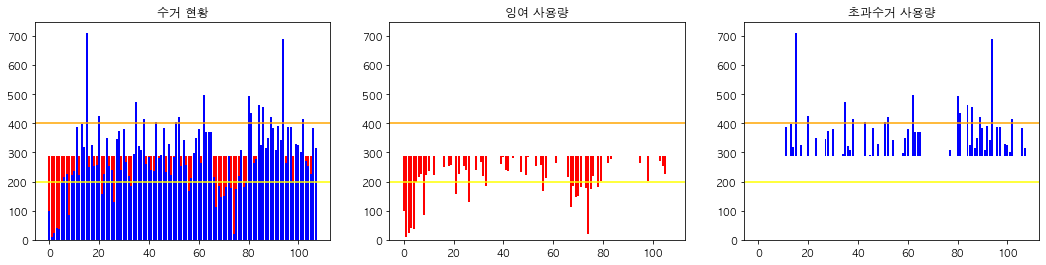

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,9396,0
수거 사용량,20054,9867,1121
잉여 사용량,1546,3328,0
초과수거 사용량,0,3799,1121


In [280]:
pa = PublicAnalysis(file_path).set_init_csv(1)

pa.set()
pa.set_calc(public_percentage=30)
print(pa.calc.public_kwh)
pa.elec_rate.col_monitor()
pa.elec_rate.col_table()

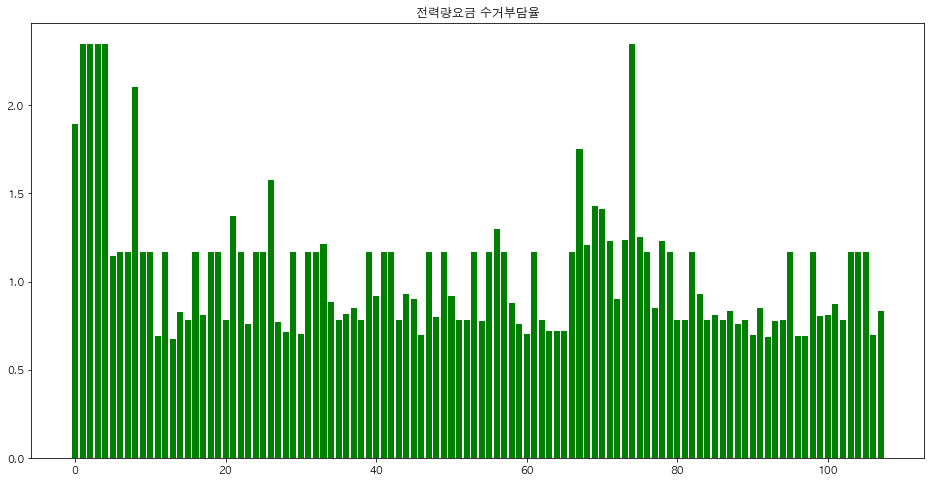

In [281]:
pa.set_calc(public_percentage=30)
basic_col_burden, elec_rate_col_burden = pa.get_col_burden()

In [282]:
elec_rate_col_burden.mean()

1.060658009900694

In [283]:
elec_rate_col_burden.std()

0.38723157797902874

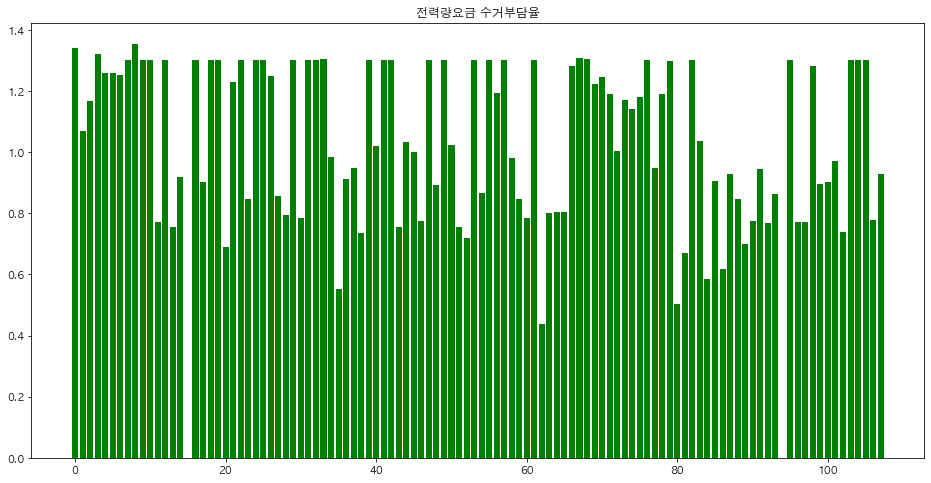

In [284]:
pa.inject_trader(pm)
pa.set_calc(public_percentage=30)
basic_col_burden, elec_rate_col_burden = pa.get_col_burden()

In [285]:
elec_rate_col_burden.mean()

1.0266165217185121

In [286]:
elec_rate_col_burden.std()

0.28205888961720527

13304


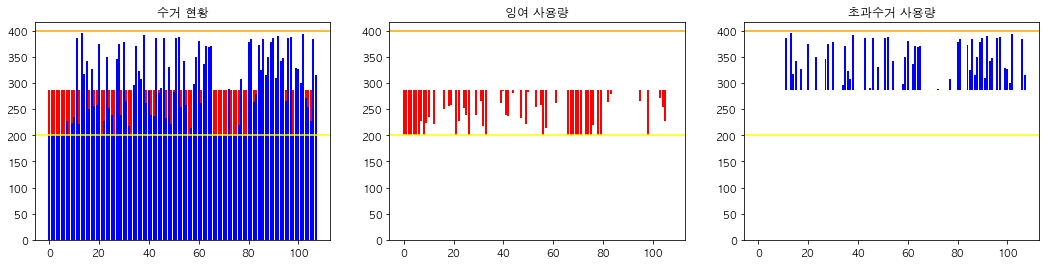

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,9396,0
수거 사용량,21600,9442,0
잉여 사용량,0,3363,0
초과수거 사용량,0,3409,0


In [240]:
pa.meter_month = pm.simulation_datas.copy()
pa.set_calc(public_percentage=30)
print(pa.calc.public_kwh)
pa.elec_rate.col_monitor()
pa.elec_rate.col_table()

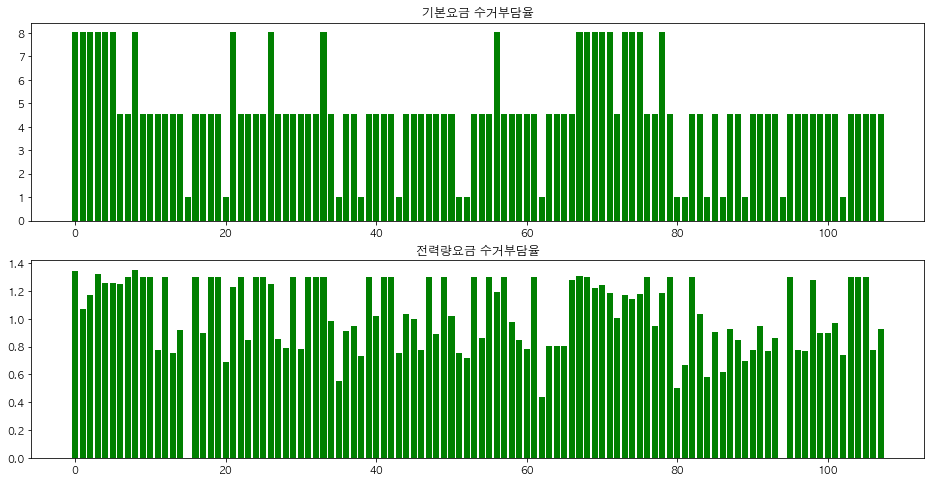

In [255]:
pa.set_calc(public_percentage=30)
basic_col_burden, elec_rate_col_burden = pa.get_col_burden()

In [245]:
pa.meter_month = pm.simulation_datas.copy()

pa.calc.public_won

2911548.0

In [252]:
pa.inject_trader(pm)

pa.set_calc(public_percentage=30)

In [251]:
pa.calc.public_won

3248550.7